In [2]:
%matplotlib inline
from __future__ import absolute_import
from __future__ import print_function
import matplotlib.pyplot as plt
import numpy as np
np.random.seed(1337)  # for reproducibility

from theano import function

from keras.datasets import mnist
from keras.models import Sequential
from keras.layers.core import Dense, Dropout, Activation, Flatten, Reshape, Layer
from keras.layers.convolutional import Convolution2D, MaxPooling2D, UpSampling2D
from keras.utils import np_utils
from keras import backend as K
from keras.callbacks import ModelCheckpoint
from keras.regularizers import l2

from seya.layers.variational import VariationalDense as VAE
from seya.layers.convolutional import GlobalPooling2D
from seya.utils import apply_model

from agnez import grid2d

batch_size = 100
nb_epoch = 100
code_size = 200

# input image dimensions
img_rows, img_cols = 28, 28
# number of convolutional filters to use
nb_filters = 32
# size of pooling area for max pooling
nb_pool = 2
# convolution kernel size
nb_conv = 7
nb_classes = 10

# the data, shuffled and split between tran and test sets
(X_train, y_train), (X_test, y_test) = mnist.load_data()

X_train = X_train.reshape(X_train.shape[0], 1, img_rows, img_cols)
X_test = X_test.reshape(X_test.shape[0], 1, img_rows, img_cols)
X_train = X_train.astype("float32")
X_test = X_test.astype("float32")
X_train /= 255
X_test /= 255

print('X_train shape:', X_train.shape)
print(X_train.shape[0], 'train samples')
print(X_test.shape[0], 'test samples')

# convert class vectors to binary class matrices
Y_train = np_utils.to_categorical(y_train, nb_classes)
Y_test = np_utils.to_categorical(y_test, nb_classes)

X_valid = X_train[50000:]
Y_valid = Y_train[50000:]
X_train = X_train[:50000]
Y_train = Y_train[:50000]

X_train shape: (60000, 1, 28, 28)
60000 train samples
10000 test samples


In [7]:
enc = Sequential()
enc.add(Convolution2D(nb_filters, nb_conv, nb_conv,
                        W_regularizer=l2(.0005),
                        border_mode='same',
                        input_shape=(1, img_rows, img_cols)))
enc.add(Dropout(.5))
enc.add(Activation('relu'))
enc.add(Convolution2D(nb_filters, 3, 3,
                        border_mode='same',
                        input_shape=(1, img_rows, img_cols)))
enc.add(Activation('tanh'))
enc.add(MaxPooling2D())
enc.add(Flatten())

pool_shape = enc.output_shape

enc.add(VAE(code_size, batch_size=batch_size, activation='tanh',
            prior_logsigma=1.7))
# enc.add(Activation(soft_threshold))

In [8]:
dec = Sequential()
dec.add(Dense(np.prod(pool_shape[1:]), input_dim=code_size))
dec.add(Reshape((nb_filters, img_rows/2, img_cols/2)))
dec.add(Activation('relu'))
dec.add(Convolution2D(nb_filters, 3, 3,
                        border_mode='same'))
dec.add(Activation('relu'))
dec.add(Convolution2D(784, 3, 3,
                        border_mode='same'))
dec.add(GlobalPooling2D())

dec.add(Activation('sigmoid'))
dec.add(Flatten())

In [9]:
model = Sequential()
model.add(enc)
model.add(dec)

model.compile(loss='binary_crossentropy', optimizer='adam')

In [10]:
cbk = ModelCheckpoint('vae/vae.hdf5', save_best_only=True)

try:
    model.fit(X_train, X_train.reshape((-1, 784)), batch_size=batch_size, nb_epoch=nb_epoch, verbose=1,
          validation_data=(X_valid, X_valid.reshape((-1, 784))), callbacks=[cbk])
except:
    pass

Train on 50000 samples, validate on 10000 samples
Epoch 1/100
50000/50000 [==============================] - 42s - loss: 1.1112 - val_loss: 0.2634
Epoch 2/100
50000/50000 [==============================] - 42s - loss: 1.0596 - val_loss: 0.1856
Epoch 3/100
50000/50000 [==============================] - 42s - loss: 1.0281 - val_loss: 0.1708
Epoch 4/100
50000/50000 [==============================] - 42s - loss: 1.0227 - val_loss: 0.1647
Epoch 5/100
50000/50000 [==============================] - 42s - loss: 1.0203 - val_loss: 0.1596
Epoch 6/100
50000/50000 [==============================] - 42s - loss: 1.0188 - val_loss: 0.1565
Epoch 7/100
50000/50000 [==============================] - 40s - loss: 1.0176 - val_loss: 0.1567
Epoch 8/100
50000/50000 [==============================] - 37s - loss: 1.0167 - val_loss: 0.1545
Epoch 9/100
50000/50000 [==============================] - 39s - loss: 1.0158 - val_loss: 0.1526
Epoch 10/100
50000/50000 [==============================] - 43s - loss: 1.015

# Sample

In [13]:
X = K.placeholder(ndim=2)
Y = dec(X)
F = function([X], Y, allow_input_downcast=True)

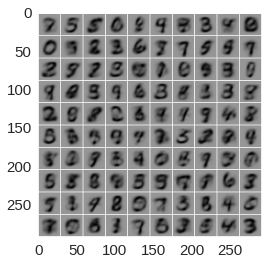

In [15]:
x = np.random.laplace(0, 1, size=(100, code_size))
y = F(x)
I = grid2d(y.reshape((100, -1)))
plt.imshow(I)

# Visualize first layers

In [16]:
W = np.asarray(K.eval(enc.layers[0].W))
W = W.reshape((32, -1))
I = grid2d(W)

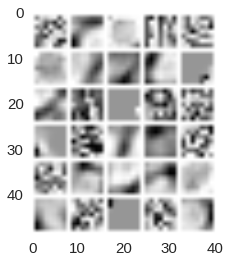

In [17]:
plt.imshow(I)